# Migration Classifier

- The classifier is trained and tested on an unseen dataset.
- Evaluation metrics such as accuracy, precision etc are obtained.

In [ ]:
import sys
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install textblob

In [2]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import pickle
import os
import numpy as np

In [3]:
def preprocess_tweets(data):
    snow = nltk.stem.SnowballStemmer('english')
    data['text'].dropna(inplace=True)
    for index, sentence in enumerate(data['text']):
        sentence = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', str(sentence))
        sentence = re.sub(r'[?|!|\'|’|"|#|@|_|:|“|”|-|"|-|-|<|>|{|}.|,|)|(|\|/]', r'', sentence)
        sentence = nltk.word_tokenize(sentence)
        words = [snow.stem(word) for word in sentence if word not in stopwords.words('english')]
        data.loc[index, 'text'] = (" ".join(map(str, words)))
    X = data['text']
    return data

In [4]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
def execute_pipeline(cl_type, x_train, x_test, y_train, y_test):
    
    if cl_type == 'svm':
        steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
        hypertuning_parameters = {'SVM__C': [0.1, 1, 9, 10, 100], 'SVM__gamma': [0.1, 1], 'SVM__kernel': ['linear']}
        label = 'SVM'
    elif cl_type == 'rf':
        steps = [('scaler', StandardScaler()), ('RF', RandomForestClassifier())]
        hypertuning_parameters = {"RF__max_features": [1, 10],
                                 "RF__min_samples_leaf": [1, 3, 10],
                                 "RF__criterion": ["gini", "entropy"]}
        label = 'RANDOM FOREST'
    elif cl_type == 'dt':
        steps = [('scaler', StandardScaler()), ('DT', DecisionTreeClassifier())]
        hypertuning_parameters = {"DT__max_features": [1, 10],
                             "DT__min_samples_leaf": [1, 3, 10]}
        label = 'DECISION TREE'
    elif cl_type == 'lr':
        steps = [('scaler', StandardScaler()), ('LR', LogisticRegression())]
        label = 'LOGISTIC REGRESSION'
        hypertuning_parameters = {}
    elif cl_type == 'lsvc':
        steps = [('scaler', StandardScaler()), ('LSVC', LinearSVC())]
        label = 'LINEAR SVC'
        hypertuning_parameters = {}
    elif cl_type == 'knn':
        steps = [('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())]
        label = 'KNN'
        hypertuning_parameters = {"KNN__algorithm": ['auto'],
                                 "KNN__weights": ['uniform'],
                                 "KNN__n_neighbors": [.1, 10]}
    
    pipeline = Pipeline(steps)
    warnings.simplefilter(action='ignore')
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    clf_model = GridSearchCV(pipeline, param_grid=hypertuning_parameters, cv=kfold)
    clf_model.fit(x_train, y_train)
    y_pred = clf_model.predict(x_test)
    
    print('--------------- ', label, '------------------')
    
    print("Accuracy = %3.2f" % (clf_model.score(x_test,y_test)))
    print("Precision = %3.2f" % (precision_score(y_test,y_pred)))
    print("Recall = %3.2f" % (recall_score(y_test,y_pred)))
    print("F1 = %3.2f" % (f1_score(y_test,y_pred)))
    
    from sklearn.metrics import confusion_matrix
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1, 0]))
    confusion = pd.DataFrame(conmat, index=['YES', 'NO'], columns=['predicted_YES', 'predicted_NO'])
    print(confusion)
    
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    predicted_probas = clf_model.predict_proba(x_test)
    skplt.metrics.plot_roc(y_test, predicted_probas)
    plt.show()

    print('\n')
    
    # return grid_score_acc

In [5]:
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])
    sum1 = sum([vec1[x] ** 2 for x in vec1.keys()])
    sum2 = sum([vec2[x] ** 2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [6]:
def compute_similarity(text1, text2):
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    return get_cosine(vector1, vector2)

In [7]:
def get_avg_cosine_similarity(data, keyword_list):
    cosine_sim = 0.0
    for keyword in keyword_list:
        cosine_sim = cosine_sim + compute_similarity(data, keyword)
    return cosine_sim

In [8]:
from collections import Counter
import math
def text_to_vector(text):
    WORD = re.compile(r'\w+')
    words = WORD.findall(text)
    return Counter(words)

In [9]:
import textblob
def check_pos_tag(x, flag):
    pos_family = {
        'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
        'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
        'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
        'adj': ['JJ', 'JJR', 'JJS'],
        'adv': ['RB', 'RBR', 'RBS', 'WRB']
    }
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

In [10]:
def get_text_based_features(tweet_text):
    char_count = tweet_text.apply(len)
    word_count = tweet_text.apply(lambda x: len(x.split()))
    word_density = char_count / (word_count + 1)

    noun_count = tweet_text.apply(lambda x: check_pos_tag(x, 'noun'))
    verb_count = tweet_text.apply(lambda x: check_pos_tag(x, 'verb'))
    adj_count = tweet_text.apply(lambda x: check_pos_tag(x, 'adj'))
    adv_count = tweet_text.apply(lambda x: check_pos_tag(x, 'adv'))
    pron_count = tweet_text.apply(lambda x: check_pos_tag(x, 'pron'))

    return word_density, noun_count, verb_count, adj_count, adv_count, pron_count

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
def get_vectorized_text(df_train, df_test):
    vect = CountVectorizer()
    vect.fit(df_train.Text)
    X_text_train = vect.transform(df_train.Text)  # documents-terms matrix of training set
    X_text_test = vect.transform(df_test.Text)

    return X_text_train, X_text_test

In [12]:
def get_classification_scores(df_joined, df_label):
    x_train, x_test, y_train, y_test = train_test_split(df_joined, df_label, test_size=0.1, random_state=42, stratify=df_label)
    x_text_train, x_text_test = get_vectorized_text(x_train, x_test)

    x_weight_train = np.atleast_2d(x_train.Weight.astype(float)).T
    x_weight_test = np.atleast_2d(x_test.Weight.astype(float)).T

    x_vc_train = np.atleast_2d(x_train.Verb_Count.astype(float)).T
    x_vc_test = np.atleast_2d(x_test.Verb_Count.astype(float)).T

    x_advc_train = np.atleast_2d(x_train.Adv_Count.astype(float)).T
    x_advc_test = np.atleast_2d(x_test.Adv_Count.astype(float)).T

    x_adjc_train = np.atleast_2d(x_train.Adj_Count.astype(float)).T
    x_adjc_test = np.atleast_2d(x_test.Adj_Count.astype(float)).T

    X_train = sp.hstack((x_text_train, x_weight_train, x_vc_train, x_advc_train, x_adjc_train)).todense() 
    X_test = sp.hstack((x_text_test, x_weight_test, x_vc_test, x_advc_test, x_adjc_test)).todense()

    execute_pipeline('svm', X_train, X_test, y_train, y_test)
    execute_pipeline('lr', X_train, X_test, y_train, y_test)
    execute_pipeline('rf', X_train, X_test, y_train, y_test)
    execute_pipeline('dt', X_train, X_test, y_train, y_test)

# Choose one of the 3 data preparation techniques from below

1. Prepare dataset that contains no bot accounts

In [13]:
import scipy.sparse as sp

keyword_list = ["refugeecrisis", "refugee", "refugeeswelcome", "referendum", "eu",
                    "syrian", "syria", "UN", "syrian refugee", "migrant", "attack", "europe", "children",
                    "state", "voters", "refugeesgr", "found", "invalid", "withrefugees",
                    "isis", "accept", "nearly", "migrant", "immigr"]

dataf = pd.read_csv('DownsampledCoreDataWithoutBots.csv', encoding='utf-8')
df = preprocess_tweets(dataf)
df_label = df['migration_relevance']

2. Prepare dataset (originally annotated) that contains bot accounts

In [ ]:
# import scipy.sparse as sp

# keyword_list = ["refugeecrisis", "refugee", "refugeeswelcome", "referendum", "eu",
#                     "syrian", "syria", "UN", "syrian refugee", "migrant", "attack", "europe", "children",
#                     "state", "voters", "refugeesgr", "found", "invalid", "withrefugees",
#                     "isis", "accept", "nearly", "migrant", "immigr"]

# dataf = pd.read_csv('DownsampledCoreData.csv', encoding='utf-8')
# df = preprocess_tweets(dataf)
# df_label = df['migration_relevant'].map({'yes': 1, 'no': 0, 'Yes': 1, 'No': 0})

3. Prepare dataset (originally annotated) that contains no bot accounts and is labelled with polarity

In [ ]:
# import scipy.sparse as sp

# keyword_list = ["refugeecrisis", "refugee", "refugeeswelcome", "referendum", "eu",
#                     "syrian", "syria", "UN", "syrian refugee", "migrant", "attack", "europe", "children",
#                     "state", "voters", "refugeesgr", "found", "invalid", "withrefugees",
#                     "isis", "accept", "nearly", "migrant", "immigr"]

# dataf = pd.read_csv('DownsampledCoreDataPolarityWithoutBots.csv', encoding='utf-8')
# df = preprocess_tweets(dataf)
# df_label = df['migration_relevance']

In [14]:
df.head()

,Unnamed: 0,created_at,tweet_id,text,migration_relevant,source,truncated,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,...,favorites_count,statuses_count,utc_offset,time_zone,geo_enabled,contributors_enabled,is_translator,following_count,lang,migration_relevance
0,0,Tue Sep 01 17:49:40 +0000 2015,6.390000e+17,jordanbos97 mean much thank thank thank,no,"<a href=""http://twitter.com/download/android"" ...",False,6.390000e+17,473000000.0,jordanbos97,...,55506,42316,-36000.0,Hawaii,True,False,False,519,en,0.0
1,1,Tue Sep 01 20:17:15 +0000 2015,6.390000e+17,rt lakershow jordan clarkson imit kobe fadeawa...,no,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,...,596,1609,-25200.0,Pacific Time (US & Canada),True,False,False,82,en,0.0
2,2,Tue Sep 01 14:12:35 +0000 2015,6.390000e+17,rt ulusoybetuel unterstand one put children bo...,no,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,...,45082,30305,7200.0,Berlin,True,False,False,790,en,0.0
3,3,Tue Sep 01 08:11:43 +0000 2015,6.390000e+17,europ tighten border stop flow migrant livelea...,no,"<a href=""http://ifttt.com"" rel=""nofollow"">IFTT...",False,NaN,NaN,NaN,...,0,168728,NaN,NaN,False,False,False,157,en,0.0
4,4,Wed Sep 02 00:52:02 +0000 2015,6.390000e+17,look like campaign poster neglect hors,no,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,...,2936,10919,NaN,NaN,False,False,False,853,en,0.0


In [15]:
df_similarity = []

for i in df.itertuples(index=True, name='Pandas'):
    df_similarity.append(get_avg_cosine_similarity(i.text, keyword_list))

df['similarity'] = df_similarity
    
df['wrd_dens'], df['noun_c'], df['verb_c'], df['adj_c'], df['adv_c'], df['pron_c'] = get_text_based_features(df['text'])
Weight = df['similarity'].fillna(0)

df_text = df['text']

# join
df_joined = pd.DataFrame(np.vstack([df_text,
                                    Weight,
                                    df['wrd_dens'],
                                    df['noun_c'],
                                    df['verb_c'],
                                    df['adj_c'],
                                    df['adv_c'],
                                    df['pron_c']]).T,
                         columns=['Text',
                                  'Weight',
                                  'Word_Density',
                                  'Noun_Count',
                                  'Verb_Count',
                                  'Adj_Count',
                                  'Adv_Count',
                                  'Pron_Count'])

df_joined.to_csv('CorrelationDataAnalysis.csv', index=False)

df_joined.head()

,Text,Weight,Word_Density,Noun_Count,Verb_Count,Adj_Count,Adv_Count,Pron_Count
0,jordanbos97 mean much thank thank thank,0,5.57143,5,0,1,0,0
1,rt lakershow jordan clarkson imit kobe fadeawa...,0,6,6,1,0,1,0
2,rt ulusoybetuel unterstand one put children bo...,0.288675,6.53846,8,1,1,0,0
3,europ tighten border stop flow migrant livelea...,0.755929,6.25,5,2,0,0,0
4,look like campaign poster neglect hors,0,5.42857,5,0,0,0,0


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('CorrelationDataAnalysis.csv')

In [17]:
df.corr(method='pearson')

,Weight,Word_Density,Noun_Count,Verb_Count,Adj_Count,Adv_Count,Pron_Count
Weight,1.000000,0.024186,0.032539,-0.088076,0.136451,-0.086145,-0.030092
Word_Density,0.024186,1.000000,0.134394,-0.048193,-0.008041,-0.090057,-0.069919
Noun_Count,0.032539,0.134394,1.000000,-0.072340,0.021871,-0.075870,-0.057638
Verb_Count,-0.088076,-0.048193,-0.072340,1.000000,0.185774,0.139736,0.142492
Adj_Count,0.136451,-0.008041,0.021871,0.185774,1.000000,0.177051,0.006317
Adv_Count,-0.086145,-0.090057,-0.075870,0.139736,0.177051,1.000000,0.073159
Pron_Count,-0.030092,-0.069919,-0.057638,0.142492,0.006317,0.073159,1.000000


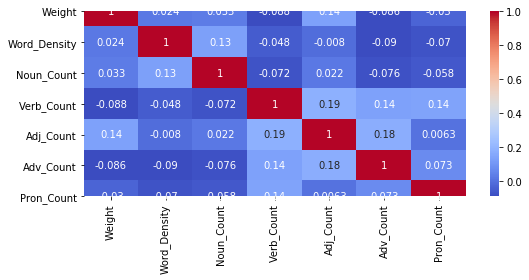

In [18]:
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(method='pearson'), cmap='coolwarm', annot=True)
plt.tight_layout()
plt.show()

# Get classification scores

---------------  SVM ------------------
Accuracy = 0.87
Precision = 0.86
Recall = 0.89
F1 = 0.87
     predicted_YES  predicted_NO
YES             24             3
NO               4            24


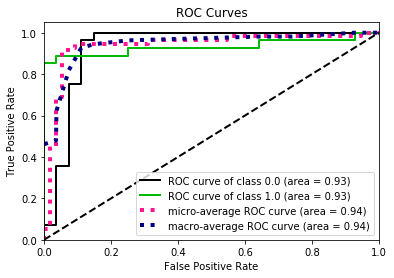



---------------  LOGISTIC REGRESSION ------------------
Accuracy = 0.87
Precision = 0.86
Recall = 0.89
F1 = 0.87
     predicted_YES  predicted_NO
YES             24             3
NO               4            24


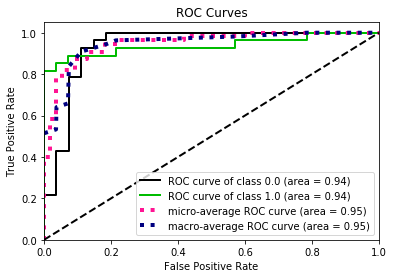



---------------  RANDOM FOREST ------------------
Accuracy = 0.95
Precision = 0.96
Recall = 0.93
F1 = 0.94
     predicted_YES  predicted_NO
YES             25             2
NO               1            27


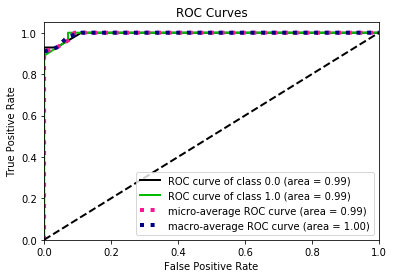



---------------  DECISION TREE ------------------
Accuracy = 0.76
Precision = 0.77
Recall = 0.74
F1 = 0.75
     predicted_YES  predicted_NO
YES             20             7
NO               6            22


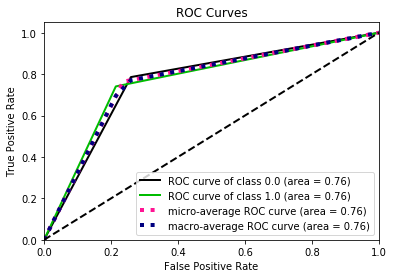

In [19]:
get_classification_scores(df_joined, df_label)